# Disclaimer
### This dataset was published on Kaggle by <a href="https://www.kaggle.com/blackmoon">АнатолийБельчиков</a>. It was used by <a href="https://www.kaggle.com/andrewkalita">me</a> just as an example of text classification in Russian language. If you speak Russian and this corpus unacceptable for you to read, please visit <a href="https://www.google.com/search?q=котики&tbm=isch">this site</a>.

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

import nltk
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
import seaborn as sns
import re

C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\Нур\AppData\Local\Temp\ipykernel_13928\120227234.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as

In [2]:
#nltk.download('averaged_perceptron_tagger_ru')

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     C:\Users\Нур\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!


True

In [4]:
dfComments = pd.read_csv('labeled.csv')
dfComments.head(10)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


In [5]:
dfComments.tail(10)

,comment,toxic
14402,"ЭЙ МИХАЛЫЧ, ТАМ ПОЖАРКА ПИЩИТ ДА ХУЙ С НЕЙ ПУЩ...",1.0
14403,Пусть лучше само евровидение стримит. Долбоеб ...,1.0
14404,"ЖЕНЩИНА это ВЕНЕЦ ТВОРЕНИЯ, помните это ваньки...",1.0
14405,Сейчас все авиакомпании мира вместе со специал...,1.0
14406,Потому что запад прошел эту хуйню еще пару сот...,0.0
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0
14411,До сих пор пересматриваю его видео. Орамбо кст...,0.0


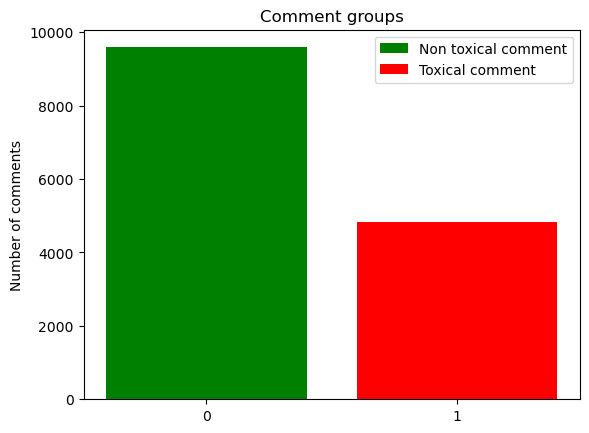

Comment description

      comment                                                               
        count unique                                                top freq
toxic                                                                       
0.0      9586   9586  В шапке были ссылки на инфу по текущему фильму...    1
1.0      4826   4826               Верблюдов-то за что? Дебилы, бл...\n    1

              toxic
count  14412.000000
mean       0.334860
std        0.471958
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [6]:
desc = dfComments.groupby('toxic').describe()

plt.bar('0', desc['comment']['count'][0], label="Non toxical comment", color='green')
plt.bar('1', desc['comment']['count'][1], label="Toxical comment", color='red')
plt.legend()
plt.ylabel('Number of comments')
plt.title('Comment groups')
plt.show()

print('Comment description\n')
print(desc)
print()
print(dfComments.describe())

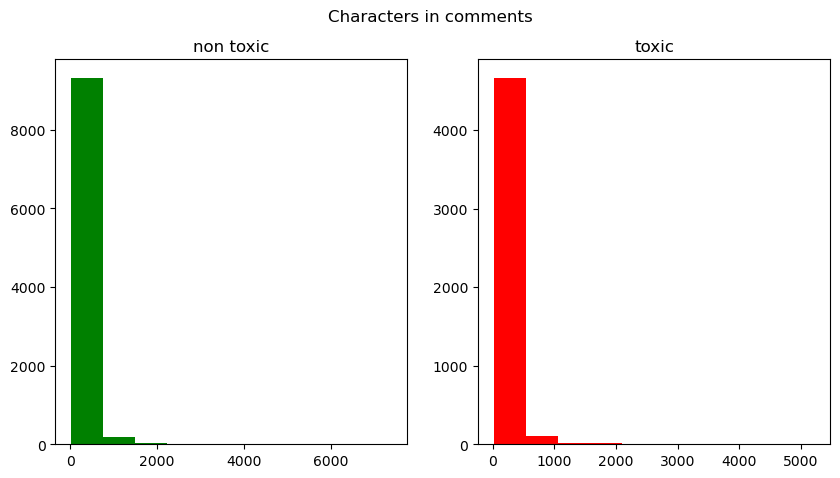

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.hist(dfComments[dfComments['toxic']==0]['comment'].str.len() ,color='green')
ax1.set_title('non toxic')

ax2.hist(dfComments[dfComments['toxic']==1]['comment'].str.len() ,color='red')
ax2.set_title('toxic')

fig.suptitle('Characters in comments')
plt.show()

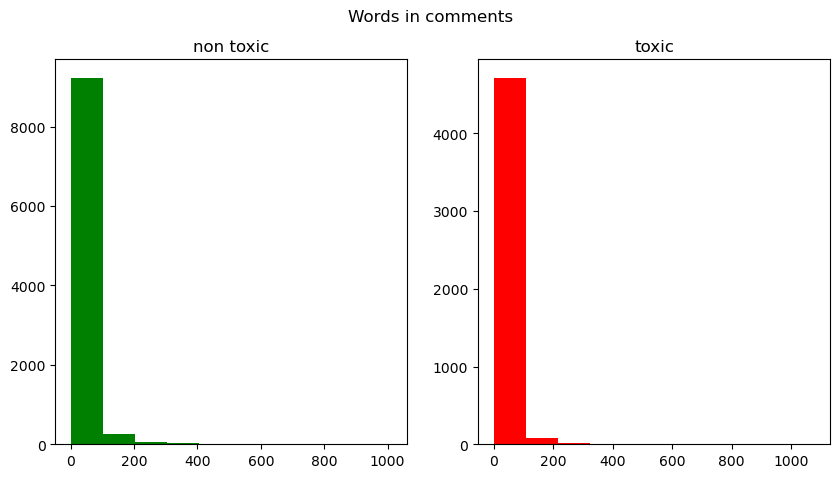

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.hist(dfComments[dfComments['toxic']==0]['comment'].str.split().map(lambda x: len(x)) ,color='green')
ax1.set_title('non toxic')

ax2.hist(dfComments[dfComments['toxic']==1]['comment'].str.split().map(lambda x: len(x)) ,color='red')
ax2.set_title('toxic')

fig.suptitle('Words in comments')
plt.show()

### Preporation

In [9]:
text = np.array(dfComments.comment.values)
target = dfComments.toxic.astype(int).values

In [10]:
def upperCaseRate(string):
    "Returns percentage of uppercase letters in the string"
    return np.array(list(map(str.isupper, string))).mean()

In [11]:
upcaseRate = list(map(upperCaseRate, dfComments.comment.values))

In [12]:
def cleanText(string):
    """This function deletes all symbols except Cyrilic and Base Latin alphabet,
    stopwords, functional parts of speech. Returns string of words stem."""
    # Common cleaning
    string = string.lower()
    string = re.sub(r"http\S+", "", string)
    string = str.replace(string,'Ё','е')
    string = str.replace(string,'ё','е')
    prog = re.compile('[А-Яа-яA-Za-z]+')
    words = prog.findall(string.lower())
    
    # Word Cleaning
    ## Stop Words
    stopwords = nltk.corpus.stopwords.words('russian')
    words = [w for w in words if w not in stopwords]
    ## Cleaning functional POS (Parts of Speech)
    functionalPos = {'CONJ', 'PRCL'}
    words = [w for w, pos in nltk.pos_tag(words, lang='rus') if pos not in functionalPos]
    ## Stemming
    stemmer = SnowballStemmer('russian')
    return ' '.join(list(map(stemmer.stem, words)))

In [13]:
%%time
text = list(map(cleanText, text))

Wall time: 44.1 s


## Proccessing

In [14]:
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=.3, stratify=target, shuffle = True, random_state=0)
print('Dim of train:', len(X_train), '\tTarget rate: {:.2f}%'.format(y_train.mean()))
print("Dim of test:", len(X_test), '\tTarget rate: {:.2f}%'.format(y_test.mean()))

Dim of train: 10088 	Target rate: 0.33%
Dim of test: 4324 	Target rate: 0.33%


In [15]:
dfComments.to_excel("kkk.xlsx")

C:\Users\Нур\AppData\Local\Temp\ipykernel_13928\2793857792.py:1: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  dfComments.to_excel("kkk.xlsx")


In [16]:
pd.DataFrame(X_train)

,0
0,павербанк подключа
1,собствен пуст след генофонд вид чищ станет d
2,оста подожда лет
3,поч друг регион друг отрасл
4,растяжк нужн удлинен мышц работа держа положен...
...,...
10083,неужел кузов предусмотр кран перенос
10084,итог пореш конин красножоп пидорас котор пытае...
10085,лиг час наигра вкладк заб туд мусорн лег скиды...
10086,сто днс роутер блоч реклам браузер приложен ютуб


## Baseline

In [17]:
clf_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()), # Prod feature: tokenizer=cleanText
            ("classifier", LinearSVC(dual=False))]
        )

clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LinearSVC(dual=False))])

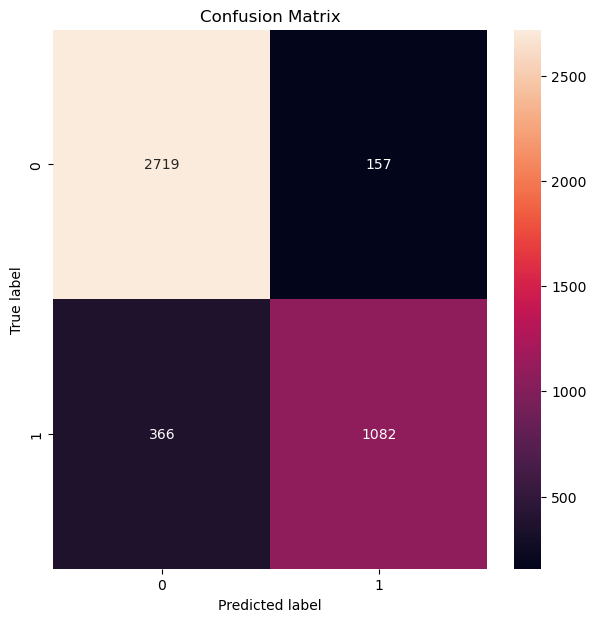

In [18]:
cm = metrics.confusion_matrix(y_test, clf_pipeline.predict(X_test))

def plotConfusionMatrix(cm):
    fig = plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None

plotConfusionMatrix(cm)

In [19]:
print(metrics.classification_report(y_test, clf_pipeline.predict(X_test)))
f1_base = metrics.f1_score(y_test, clf_pipeline.predict(X_test))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2876
           1       0.87      0.75      0.81      1448

    accuracy                           0.88      4324
   macro avg       0.88      0.85      0.86      4324
weighted avg       0.88      0.88      0.88      4324



## Adjusts

In [20]:
#print('\n'.join(clf_pipeline.get_params().keys()))

In [21]:
parameters = {'vectorizer__max_features': (10**3, 10**4),
              'vectorizer__ngram_range': ((1, 2),(2, 3)),
              'classifier__penalty': ('l1','l2'),
              'classifier__C': (range(1,10,2))
             }

In [22]:
gs_clf = GridSearchCV(clf_pipeline, parameters,  cv = 4, n_jobs=-1)
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', LinearSVC(dual=False))]),
             n_jobs=-1,
             param_grid={'classifier__C': range(1, 10, 2),
                         'classifier__penalty': ('l1', 'l2'),
                         'vectorizer__max_features': (1000, 10000),
                         'vectorizer__ngram_range': ((1, 2), (2, 3))})

In [23]:
print(metrics.classification_report(y_test, gs_clf.predict(X_test)))
f1_gsLSVC = metrics.f1_score(y_test, gs_clf.predict(X_test))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2876
           1       0.85      0.74      0.79      1448

    accuracy                           0.87      4324
   macro avg       0.86      0.84      0.85      4324
weighted avg       0.87      0.87      0.87      4324



### Randomized Search CV on TfidfVectorizer and LogisticRegression

In [24]:
parameters = { 'vectorizer__max_features': (10**2, 10**3),
              'vectorizer__ngram_range': [(1, 2),(1, 3)],
              'vectorizer__min_df': [0.,.2,.4,.6,.8,1],
              'classifier__penalty': ('l1','l2'),
              'classifier__C': (range(1,10,2)),
             }

In [25]:
clf_pipeline_LogitReg = Pipeline(
            [("vectorizer", TfidfVectorizer()),
            ("classifier", LogisticRegression())]
        )

In [26]:
def plotROC(y_test, probs, titl=''):
    if titl!='':
        titl = ' ('+titl+')' 
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic'+titl)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return None

D:\Tool\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
24 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Tool\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Tool\anaconda\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Tool\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Tool\anaco

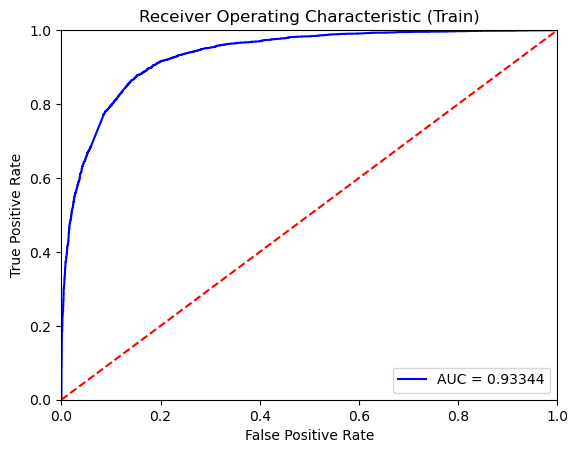

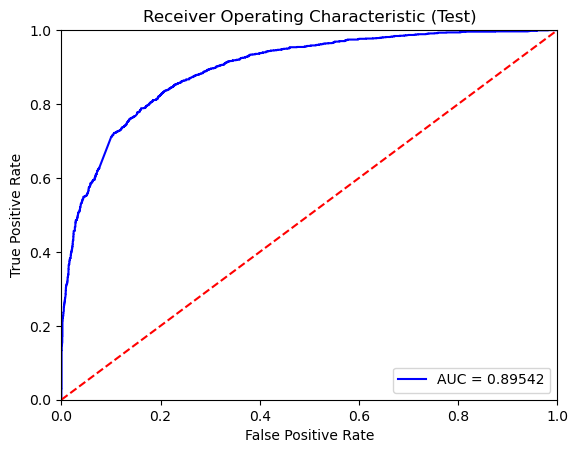

Wall time: 7.38 s


In [27]:
%%time
rndgs_clf_LogitReg = RandomizedSearchCV(clf_pipeline_LogitReg, parameters, scoring='f1', cv = 4, n_jobs=-1)
rndgs_clf_LogitReg.fit(X_train, y_train)

probs = rndgs_clf_LogitReg.predict_proba(X_train)[:,1]
plotROC(y_train, probs, 'Train')

probs = rndgs_clf_LogitReg.predict_proba(X_test)[:,1]
plotROC(y_test, probs, 'Test')

Looks like overfited model. There's too high AUC on train.

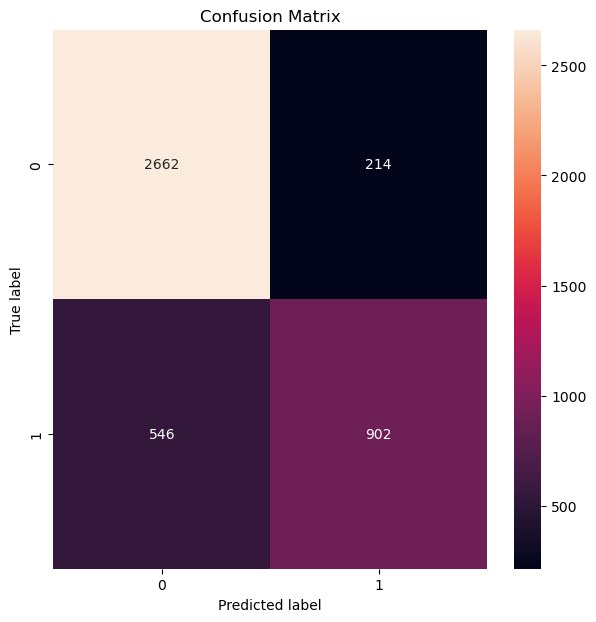

In [28]:
plotConfusionMatrix(metrics.confusion_matrix(y_test, rndgs_clf_LogitReg.predict(X_test)))

In [29]:
print(metrics.classification_report(y_test, rndgs_clf_LogitReg.predict(X_test)))
f1_rndLogR = metrics.f1_score(y_test, rndgs_clf_LogitReg.predict(X_test))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      2876
           1       0.81      0.62      0.70      1448

    accuracy                           0.82      4324
   macro avg       0.82      0.77      0.79      4324
weighted avg       0.82      0.82      0.82      4324



### Add more parameters

D:\Tool\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
16 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Tool\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Tool\anaconda\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Tool\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Tool\anacon

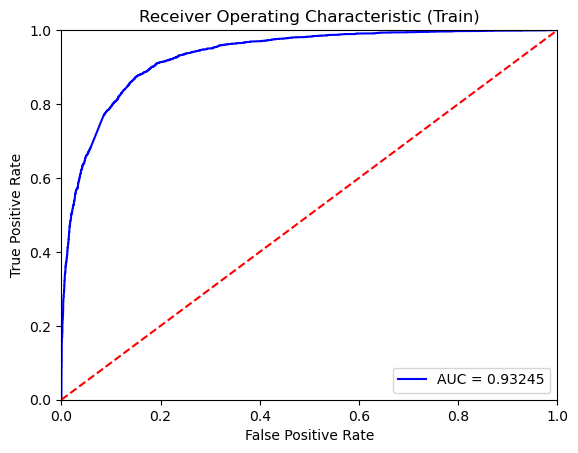

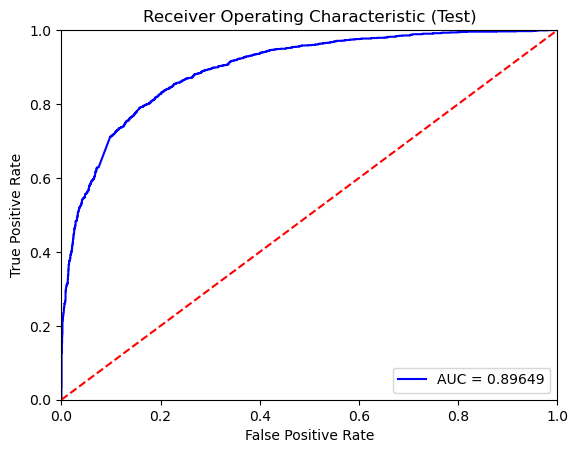

Wall time: 8.78 s


In [32]:
%%time
parameters = {'vectorizer__max_features': (10**2, 10**3),
              'vectorizer__ngram_range': [(1, 2),(1, 3)],
              'vectorizer__min_df': [0.,.2,.4,.6,.8,1],
              'classifier__penalty': ('l1','l2'),
              'classifier__C': (range(1,10,2)),
             }

clf_pipeline_LogitReg = Pipeline(
            [("vectorizer", TfidfVectorizer()),
            ("classifier", LogisticRegression())]
        )

rndgs_clf_LogitReg = RandomizedSearchCV(clf_pipeline_LogitReg, parameters, scoring='f1', cv = 4, n_jobs=-1)
rndgs_clf_LogitReg.fit(X_train, y_train)

probs = rndgs_clf_LogitReg.predict_proba(X_train)[:,1]
plotROC(y_train, probs, 'Train')

probs = rndgs_clf_LogitReg.predict_proba(X_test)[:,1]
plotROC(y_test, probs, 'Test')

In [33]:
print(metrics.classification_report(y_test, rndgs_clf_LogitReg.predict(X_test)))
f1_rndLogR_2 = metrics.f1_score(y_test, rndgs_clf_LogitReg.predict(X_test))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      2876
           1       0.82      0.62      0.70      1448

    accuracy                           0.83      4324
   macro avg       0.82      0.77      0.79      4324
weighted avg       0.82      0.83      0.82      4324



In [34]:
pd.DataFrame([f1_base, f1_gsLSVC, f1_rndLogR, f1_rndLogR_2], index=['BaseLine', 'GS_LSVC', 'rndGS_LogR', 'rndGS_LogR_Adj'], columns=['f1 score'])

,f1 score
BaseLine,0.805359
GS_LSVC,0.790406
rndGS_LogR,0.703588
rndGS_LogR_Adj,0.704358


## Базовый алгоритм выглядит простым и достаточно хорошим. Матрица путаницы тоже неплоха. Однако логистическая регрессия прогнозирует вероятности классификации. Следовательно, мы можем построить кривую оператора приемника (ROC) и получить значение AUC (площадь под кривой). Это может оказаться полезным для следующих улучшений этого ноутбука.